In [1]:
import torch 
import torchvision

torch.__version__

'2.4.0'

# defining the dataset 

The dataset __getitem__ should return a tuple: 
* **Image**: an image tensor of shape [3, H, W], a pure tensor, or a PIL Image of size (H, W).
* **target**: a dict containing the following fields
    * boxes, torchvision.tv_tensors.BoundingBoxes of shape [N, 4]: the coordinates of the N bounding boxes in **[x0, y0, x1, y1]** format, ranging from 0 to W and 0 to H.
    * labels, integer torch.Tensor of shape [N]: the lable for each bounding box. 0 represents always the background class. 
    * image_id, int: an image identifier. 
    * area, float torch.Tensor of shape [N]: the area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium, and large boxes.
    * iscrowd, uint8 torch.Tensor of shape [N]: instances with iscrowd=True will be ignored during evaluation. 
    * (optional) masks, torchvision.tv_tensors.Mask of shape [N, H, W]: the segmentation masks for each one of the objects

In [2]:
from utils import download_data

download_data(source="https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip", destination="PennFudanPed", remove_source=True)

[INFO] data\PennFudanPed directory exists, skipping download.


WindowsPath('data/PennFudanPed')

torch.Size([3, 438, 567])


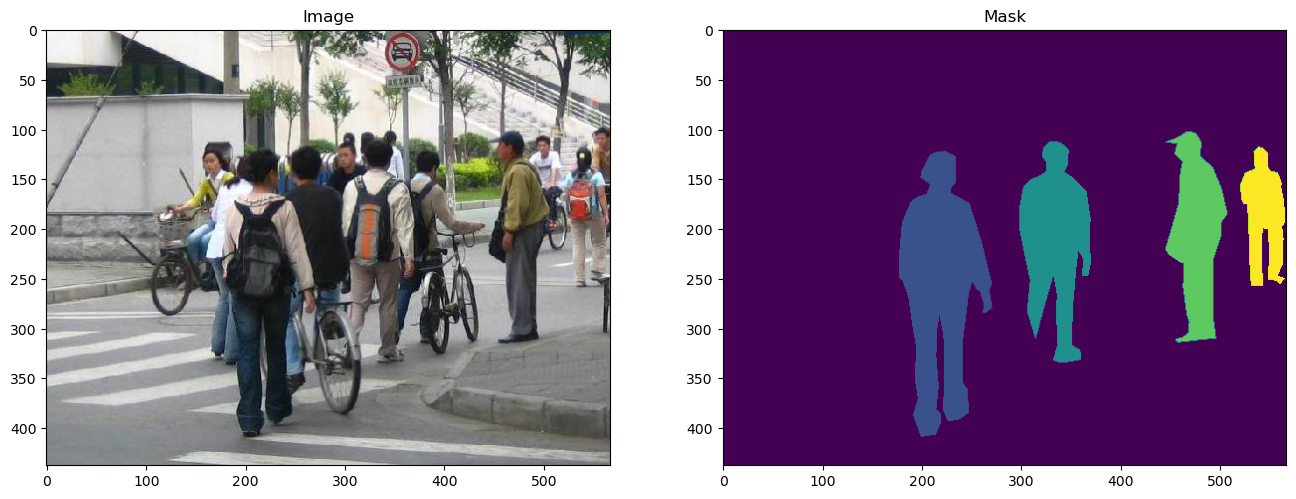

In [3]:
import matplotlib.pyplot as plt 
from torchvision.io import read_image 

image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

print(image.shape)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

# Setup custom dataset

We're gonna wrap the data using the dataset class in this form: 
* image tensors will be wrapped by `torchvision.tv_tensors.Image` 
* bounding boces into `torchvision.tv_tensors.BoundingBoxes`
* masks into `torchvision.tv_tensors.Mask`

In [4]:
import os 
import torch 

from torchvision.io import read_image 
from torchvision.ops.boxes import masks_to_boxes 
from torchvision import tv_tensors 
from torchvision.transforms.v2 import functional as F
from pathlib import Path

In [5]:
list(sorted(os.listdir(os.path.join(Path("data/PennFudanPed"), "PedMasks"))))[:5], list(sorted(os.listdir(os.path.join(Path("data/PennFudanPed"), "PNGImages"))))[:5]

(['FudanPed00001_mask.png',
  'FudanPed00002_mask.png',
  'FudanPed00003_mask.png',
  'FudanPed00004_mask.png',
  'FudanPed00005_mask.png'],
 ['FudanPed00001.png',
  'FudanPed00002.png',
  'FudanPed00003.png',
  'FudanPed00004.png',
  'FudanPed00005.png'])

In [6]:
import os 
import torch 

from torchvision.io import read_image 
from torchvision.ops.boxes import masks_to_boxes 
from torchvision import tv_tensors 
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root 
        self.transforms = transforms 
        # ensure the loaded image files with the masks are aligned
        self.images = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks 
        img_path = os.path.join(self.root, "PNGImages", self.images[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors 
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set 
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask 
        boxes = masks_to_boxes(masks) 
        # there is only one class 
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx 
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd 
        iscrowd = torch.zeros((num_objs, ), dtype=torch.int64)

        # wrap sample and targets into torchvision tv_tensors 
        img = tv_tensors.Image(img) 

        target = {} 
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks) 
        target["labels"] = labels 
        target["image_id"] = image_id
        target["area"] = area 
        target["iscrowd"] = iscrowd 

        if self.transforms: 
            img, target = self.transforms(img, target)
        return img, target 
    
    def __len__(self):
        return len(self.images)

# Defining Mask R-CNN for object recognition model and instance segmentation model

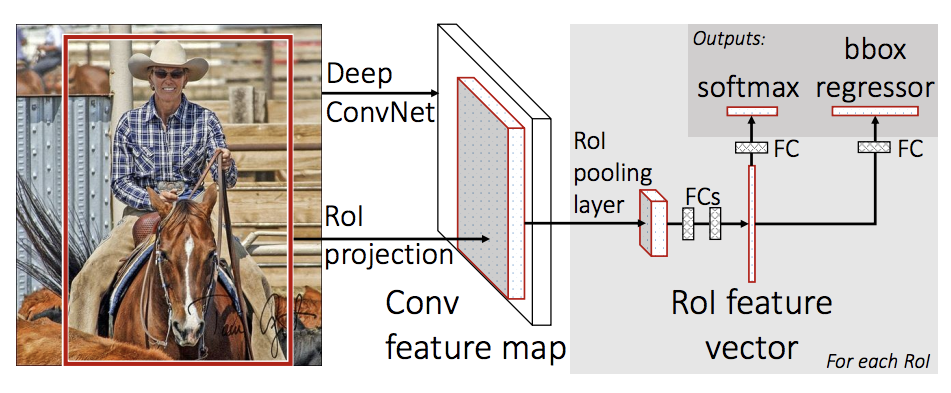
_Faster R-CNN model architecture_ 

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

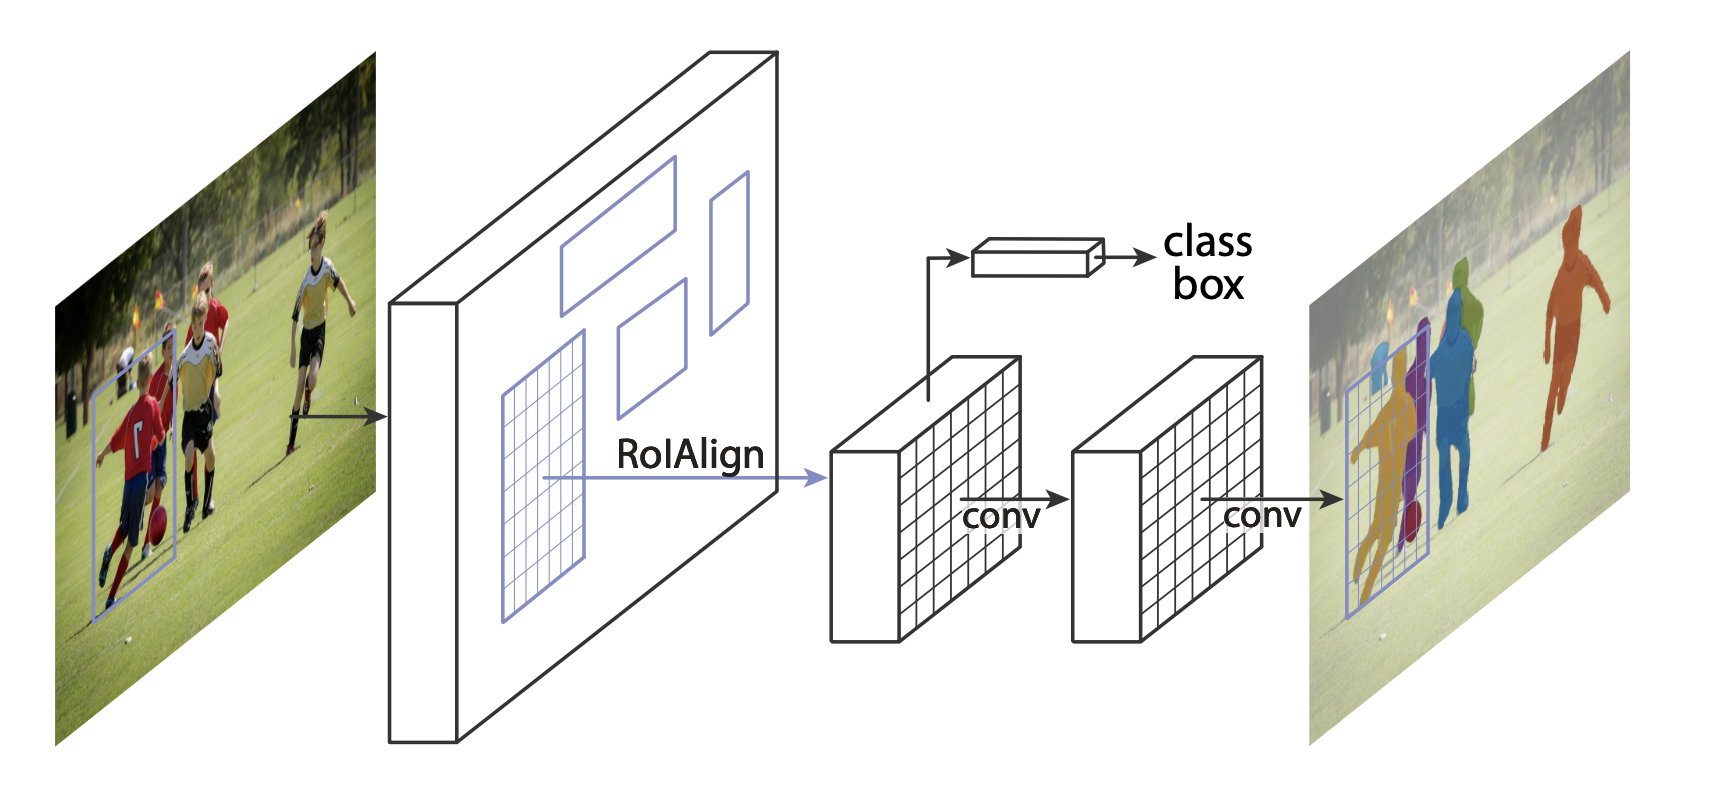

There are two common situations where one might want to modify one of the available models in TorchVision Model Zoo. The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

## Finetuning from a pretrained model

In [7]:
import torchvision 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor 

# load a model pre-trained on COCO dataset 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one
num_classes = 2 # 1 class (person) + background
# get number of input features for the classifier 
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new on e
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [8]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Modifying the model to add a different backbone 

In [9]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Putting everything together 

In `references/detection/`, we have a number of helper functions to simplify training and evaluating detection models. Here, we will use references/detection/engine.py and references/detection/utils.py. Just download everything under references/detection to your folder and use them here.

In [10]:
import requests

url_dict = {"engine.py": "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py", 
            "coco_utils.py": "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py", 
            "coco_eval.py": "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py", 
            "transforms.py": "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py"}

for f_name, url in url_dict.items(): 
    if Path(f_name).is_file():
        print(f"{f_name} already exist! skipping download")
    else: 
        print(f"writing {f_name}")
        with open(f_name, "wb") as f: 
            request = requests.get(url)
            f.write(request.content)
print("[INFO] done!")

engine.py already exist! skipping download
coco_utils.py already exist! skipping download
coco_eval.py already exist! skipping download
transforms.py already exist! skipping download
[INFO] done!


## object detection and instance segmentation model for PennFudan dataset

create a function to make a `ready` model to be trained and evaluated on the custom dataset

In [11]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor 
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor 

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO 
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one 
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # get the number of input features for the mask classifier 
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels 
    hidden_layer = 256 
    # and replace the mask predictor with a new one 
    model.roi_heads.mask_predictor = MaskRCNNPredictor( 
        in_features_mask, 
        hidden_layer, 
        num_classes
    )

    return model

In [12]:
# helper for data augmentation/transformation 
from torchvision.transforms import v2 as T 

def get_transform(train): 
    transforms = [] 
    if train: 
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [13]:
get_transform(True)

Compose(
      RandomHorizontalFlip(p=0.5)
      ToDtype(scale=True)
      ToPureTensor()
)

## Testing forward() method

In [14]:
import utils 

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset("data/PennFudanPed", get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size = 2, 
    shuffle=True, 
    collate_fn=utils.collate_fn
)

# for training 
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets) # returns losses and detections 
print(output)

# for inference 
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 
print(predictions[0])

{'loss_classifier': tensor(0.0348, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0459, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0106, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0058, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


# training.. 

In [17]:
from engine import train_one_epoch, evaluate 

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

num_classes = 2  
dataset = PennFudanDataset("data/PennFudanPed", get_transform(True))
dataset_test = PennFudanDataset("data/PennFudanPed", get_transform(False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders 
data_loader = torch.utils.data.DataLoader( 
    dataset, 
    batch_size=2, 
    shuffle=True, 
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader( 
    dataset_test, 
    batch_size=1, 
    shuffle=False, 
    collate_fn=utils.collate_fn
)

# get the model using the helper function
model = get_model_instance_segmentation(num_classes).to(device)

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=3, 
    gamma=0.1
)

num_epochs = 2 

for epoch in range(num_epochs): 
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

c:\Users\bolth\xplora\machine-learning\pedestrian-detection\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:02:04  lr: 0.000090  loss: 3.6942 (3.6942)  loss_classifier: 0.7493 (0.7493)  loss_box_reg: 0.3887 (0.3887)  loss_mask: 2.5309 (2.5309)  loss_objectness: 0.0134 (0.0134)  loss_rpn_box_reg: 0.0119 (0.0119)  time: 2.0686  data: 0.0236  max mem: 2375
Epoch: [0]  [10/60]  eta: 0:01:02  lr: 0.000936  loss: 1.3275 (2.0378)  loss_classifier: 0.5009 (0.5055)  loss_box_reg: 0.2734 (0.2949)  loss_mask: 0.6434 (1.2126)  loss_objectness: 0.0173 (0.0185)  loss_rpn_box_reg: 0.0045 (0.0064)  time: 1.2572  data: 0.0317  max mem: 2763
Epoch: [0]  [20/60]  eta: 0:00:51  lr: 0.001783  loss: 1.0106 (1.4030)  loss_classifier: 0.2376 (0.3605)  loss_box_reg: 0.2414 (0.2767)  loss_mask: 0.3104 (0.7427)  loss_objectness: 0.0155 (0.0176)  loss_rpn_box_reg: 0.0037 (0.0057)  time: 1.2491  data: 0.0358  max mem: 3223
Epoch: [0]  [30/60]  eta: 0:00:37  lr: 0.002629  loss: 0.5999 (1.1163)  loss_classifier: 0.1116 (0.2688)  loss_box_reg: 0.2110 (0.2556)  loss_mask: 0.2063 (0.5717)  loss_ob

In [19]:
from PIL import Image

In [36]:
from torchvision import transforms 

manual_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

<class 'PIL.Image.Image'>


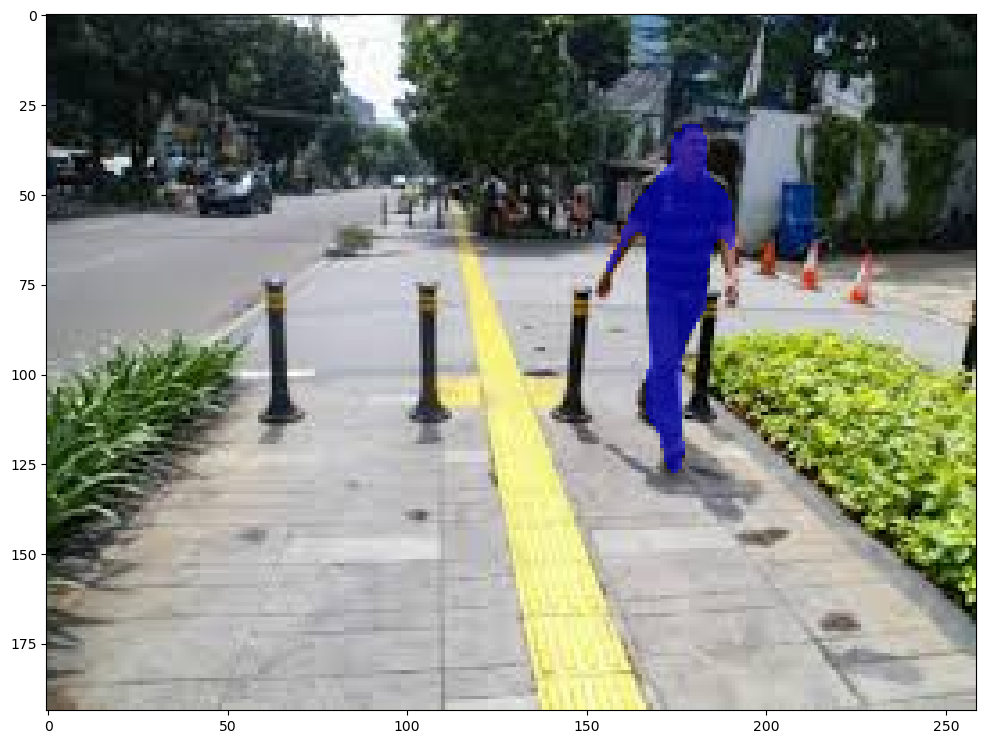

In [42]:
import matplotlib.pyplot as plt 
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks 

#img = read_image("data/PennFudanPed/PNGImages/FudanPed00045.png")
image = Image.open(requests.get("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7s_zwgj0x88eJSQyE1Av8Z8Io5W6G7hbvVg&s", stream=True).raw).convert("RGB")
eval_transform = get_transform(False)

model.eval()
with torch.inference_mode(): 
    x = manual_transform(image).to(device)
    print(type(image))
    # convert RGBA to RGB
    predictions = model([x, ])
    pred = predictions[0]

#image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(x, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(x, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.cpu().permute(1, 2, 0))